# Predicting Chronic Kidney Disease

### Overview
The data used in this investigation of chronic kidney disease is taken from a Kaggle dataset which was added by the Co-learning Lounge - https://www.kaggle.com/colearninglounge/chronic-kidney-disease, with acknowledgments to https://archive.ics.uci.edu/ml/datasets/Chronic_Kidney_Disease for the original data source.

The data has been taken over a two-month period in India, and includes 25 variables, mostly related to the patient's blood.

The target of this investigation is to determine whether or not the patient has chronic kidney disease.

A few models will be tried, starting with logistic regression since it is used to explain the relationship between one dependent binary variable (disease present or not) and one or more nominal, ordinal, interval or ratio-level independent variables.

(strategy for solving the problem, including discussion of the expected solution)

### Load the appropriate libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix


### Load the kidney disease data

In [2]:
df = pd.read_csv("kidney_disease_train.csv")
df_test = pd.read_csv("kidney_disease_test.csv")


In [3]:
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,157,62.0,70.0,1.025,3.0,0.0,normal,abnormal,notpresent,notpresent,...,39.0,7900,3.9,yes,yes,no,good,no,no,ckd
1,109,54.0,70.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,NaN,NaN,NaN,no,yes,no,good,no,no,ckd
2,17,47.0,80.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,NaN,NaN,NaN,yes,no,no,poor,no,no,ckd
3,347,43.0,60.0,1.025,0.0,0.0,normal,normal,notpresent,notpresent,...,43.0,7200,5.5,no,no,no,good,no,no,notckd
4,24,42.0,100.0,1.015,4.0,0.0,normal,abnormal,notpresent,present,...,39.0,8300,4.6,yes,no,no,poor,no,no,ckd


In [4]:
df_test.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane
0,209,19.0,70.0,1.020,0.0,0.0,NaN,normal,notpresent,notpresent,...,11.5,NaN,6900.0,NaN,no,no,no,good,no,no
1,280,47.0,80.0,NaN,NaN,NaN,NaN,NaN,notpresent,notpresent,...,13.3,52,8100.0,5.2,no,no,no,good,no,no
2,33,60.0,100.0,1.020,2.0,0.0,abnormal,abnormal,notpresent,notpresent,...,10.1,29,NaN,NaN,yes,no,no,poor,no,no
3,210,59.0,100.0,1.015,4.0,2.0,normal,normal,notpresent,notpresent,...,7.3,20,9800.0,3.9,yes,yes,yes,good,no,yes
4,93,73.0,100.0,1.010,3.0,2.0,abnormal,abnormal,present,notpresent,...,9.2,30,7000.0,3.2,yes,yes,yes,poor,no,no


In [5]:
len(df)


280

In [6]:
len(df_test)


120

There are 400 rows, where 70% are for training and 30% are for testing.

In [7]:
df.drop_duplicates()
df_test.drop_duplicates()
len(df)


280

In [8]:
len(df_test)


120

### Data types

In [9]:
df.dtypes

id                  int64
age               float64
bp                float64
sg                float64
al                float64
su                float64
rbc                object
pc                 object
pcc                object
ba                 object
bgr               float64
bu                float64
sc                float64
sod               float64
pot               float64
hemo              float64
pcv               float64
wc                 object
rc                 object
htn                object
dm                 object
cad                object
appet              object
pe                 object
ane                object
classification     object
dtype: object

### Check whether the target data is balanced
Does the patient have chronic kidney disease or not?

- ckd       Has chronic kidney disease
- notckd    Does not have chronic kidney disease

In [46]:
df.classification.value_counts()

1    174
0    106
Name: classification, dtype: int64

### Plot outliers for each numerical feature

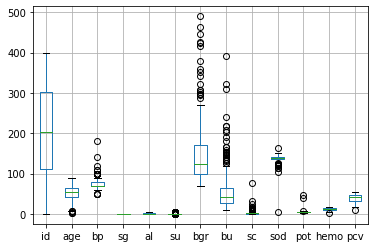

In [11]:
df.boxplot()


### Rename columns to clarify abbreviations and to show full names on plots

In [12]:
df = df.rename(columns={'bp': 'blood_pressure','sg': 'specific_gravity','al': 'albumin','su': 'sugar',
                   'rbc': 'red_blood_cells','pc': 'pus_cell','pcc': 'pus_cell_clumps','ba': 'bacteria',
                   'bgr': 'blood_glucose_random','bu': 'blood_urea','sc': 'serum_creatinine',
                   'sod': 'sodium','pot': 'potassium','hemo': 'hemoglobin','pcv': 'packed_cell_volume',
                   'wc': 'white_blood_cell','rc': 'red_blood_cell','htn': 'hypertension','dm': 'diabetes_mellitus',
                   'cad': 'coronary_artery_disease','appet': 'appetite','pe': 'pedal_edema','ane': 'anemia'})


### Coerce numerical values from string to float

In [13]:
df['white_blood_cell'] = pd.to_numeric(df['white_blood_cell'], errors='coerce')
df['red_blood_cell'] = pd.to_numeric(df['red_blood_cell'], errors='coerce')

### Create boolean values for each object feature

In [14]:
df.red_blood_cells = df.red_blood_cells.map({ 'normal' : 1, 'abnormal' : 0})
df.pus_cell = df.pus_cell.map({ 'normal' : 1, 'abnormal' : 0})
df.pus_cell_clumps = df.pus_cell_clumps.map({ 'present' : 1, 'notpresent' : 0})
df.bacteria = df.bacteria.map({ 'present' : 1, 'notpresent' : 0})
df.hypertension = df.hypertension.map({ 'yes' : 1, 'no' : 0})
df.diabetes_mellitus = df.diabetes_mellitus.map({ 'yes' : 1, '\tyes' : 1, '\tno' : 0, 'no' : 0})
df.coronary_artery_disease = df.coronary_artery_disease.map({ 'yes' : 1, 'no' : 0, '\tno' : 0})
df.appetite = df.appetite.map({ 'good' : 1, 'poor' : 0})
df.pedal_edema = df.pedal_edema.map({ 'yes' : 1, 'no' : 0})
df.anemia = df.anemia.map({ 'yes' : 1, 'no' : 0})
df.classification = df.classification.map({ 'ckd' : 1, 'notckd' : 0})

In [15]:
df.columns

Index(['id', 'age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar',
       'red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
       'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell',
       'red_blood_cell', 'hypertension', 'diabetes_mellitus',
       'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia',
       'classification'],
      dtype='object')

### Check how many null values are in the data set

In [16]:
df.isnull().sum()

id                           0
age                          5
blood_pressure               9
specific_gravity            36
albumin                     35
sugar                       38
red_blood_cells            107
pus_cell                    50
pus_cell_clumps              4
bacteria                     4
blood_glucose_random        33
blood_urea                  14
serum_creatinine            12
sodium                      67
potassium                   68
hemoglobin                  39
packed_cell_volume          51
white_blood_cell            78
red_blood_cell              94
hypertension                 1
diabetes_mellitus            1
coronary_artery_disease      1
appetite                     0
pedal_edema                  0
anemia                       0
classification               0
dtype: int64

# Imputing Data
### Fill the null values with the median value of each column then remove outliers

We will fill in NaN values with suitable numbers. We don't want to lose features like red_blood_cells which is missing 107 out of 280 values, and we have filled object-type columns with boolean values so the median of each feature column will be used (instead of the mean).

In [17]:
df.describe()

,id,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,...,packed_cell_volume,white_blood_cell,red_blood_cell,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,classification
count,280.000000,275.000000,271.000000,244.000000,245.000000,242.000000,173.000000,230.000000,276.000000,276.000000,...,229.000000,202.000000,186.000000,279.000000,279.000000,279.000000,280.000000,280.000000,280.000000,280.000000
mean,202.928571,51.454545,76.051661,1.017439,1.024490,0.438017,0.832370,0.786957,0.094203,0.057971,...,39.165939,8354.950495,4.706452,0.365591,0.362007,0.082437,0.778571,0.182143,0.142857,0.621429
std,111.988168,17.476176,14.256289,0.005746,1.375805,1.073193,0.374622,0.410351,0.292641,0.234113,...,8.774388,3107.125537,1.029280,0.482461,0.481444,0.275524,0.415952,0.386653,0.350554,0.485899
min,1.000000,2.000000,50.000000,1.005000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.000000,2200.000000,2.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,110.500000,42.000000,70.000000,1.010000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,33.000000,6325.000000,3.925000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,202.000000,55.000000,70.000000,1.020000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,41.000000,7900.000000,4.800000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
75%,302.250000,65.000000,80.000000,1.020000,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,46.000000,9800.000000,5.500000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,399.000000,90.000000,180.000000,1.025000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,...,54.000000,26400.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
def fill_nans():
    for col in df.columns:
        if df[col].dtype == 'float64':
            new_col = str(col + '_filled')
            df[new_col] = df[col].transform(lambda x: x.fillna(x.median()))
    return df

fill_nans()

,id,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,...,serum_creatinine_filled,sodium_filled,potassium_filled,hemoglobin_filled,packed_cell_volume_filled,white_blood_cell_filled,red_blood_cell_filled,hypertension_filled,diabetes_mellitus_filled,coronary_artery_disease_filled
0,157,62.0,70.0,1.025,3.0,0.0,1.0,0.0,0.0,0.0,...,1.7,136.0,4.7,12.6,39.0,7900.0,3.9,1.0,1.0,0.0
1,109,54.0,70.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,1.9,138.0,4.4,11.7,41.0,7900.0,4.8,0.0,1.0,0.0
2,17,47.0,80.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,5.2,139.0,3.7,12.1,41.0,7900.0,4.8,1.0,0.0,0.0
3,347,43.0,60.0,1.025,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,144.0,5.0,17.8,43.0,7200.0,5.5,0.0,0.0,0.0
4,24,42.0,100.0,1.015,4.0,0.0,1.0,0.0,0.0,1.0,...,1.4,129.0,4.0,11.1,39.0,8300.0,4.6,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,71,46.0,60.0,1.010,1.0,0.0,1.0,1.0,0.0,0.0,...,3.3,141.0,4.0,9.8,28.0,14600.0,3.2,1.0,1.0,0.0
276,106,50.0,90.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,6.1,127.0,4.4,6.0,17.0,6500.0,4.8,1.0,1.0,0.0
277,270,23.0,80.0,1.025,0.0,0.0,1.0,1.0,0.0,0.0,...,1.1,145.0,4.0,14.3,41.0,7200.0,5.0,0.0,0.0,0.0
278,348,38.0,80.0,1.020,0.0,0.0,1.0,1.0,0.0,0.0,...,0.5,147.0,3.5,13.6,44.0,7300.0,6.4,0.0,0.0,0.0


### Re-check how many null values are in the data set

In [19]:
df.isnull().sum()

id                                  0
age                                 5
blood_pressure                      9
specific_gravity                   36
albumin                            35
sugar                              38
red_blood_cells                   107
pus_cell                           50
pus_cell_clumps                     4
bacteria                            4
blood_glucose_random               33
blood_urea                         14
serum_creatinine                   12
sodium                             67
potassium                          68
hemoglobin                         39
packed_cell_volume                 51
white_blood_cell                   78
red_blood_cell                     94
hypertension                        1
diabetes_mellitus                   1
coronary_artery_disease             1
appetite                            0
pedal_edema                         0
anemia                              0
classification                      0
age_filled  

### The new columns have no NaN values, so we'll drop the original columns and use the newly filled columns.
### A new dataframe will be created with the filled columns

In [20]:
# Drop columns which have not been filled
new_df = df.drop(columns=['age', 'blood_pressure', 'specific_gravity',
                          'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
                          'pus_cell_clumps', 'bacteria','blood_glucose_random',
                          'blood_urea', 'serum_creatinine', 'sodium','potassium',
                          'hemoglobin', 'packed_cell_volume', 'white_blood_cell',
                          'red_blood_cell', 'hypertension', 'diabetes_mellitus',
                          'coronary_artery_disease'])

# Re-order columns to match the original df
new_df = new_df[['id', 'age_filled', 'blood_pressure_filled',
           'specific_gravity_filled', 'albumin_filled', 'sugar_filled',
           'red_blood_cells_filled', 'pus_cell_filled', 'pus_cell_clumps_filled',
           'bacteria_filled', 'blood_glucose_random_filled', 'blood_urea_filled',
           'serum_creatinine_filled', 'sodium_filled', 'potassium_filled',
           'hemoglobin_filled', 'packed_cell_volume_filled',
           'white_blood_cell_filled', 'red_blood_cell_filled',
           'hypertension_filled', 'diabetes_mellitus_filled',
           'coronary_artery_disease_filled','appetite',
           'pedal_edema', 'anemia','classification']]

### Find and remove outliers
- An assumption of binary logistic regression is there should be no outliers in the data
- Identify outliers using the Tukey rule

In [21]:
def find_outliers(col):
    
    # Calculate the first quartile
    Q1 = df[col].quantile(.25)

    # Calculate the third quartile
    Q3 = df[col].quantile(.75)

    # Calculate the interquartile range Q3 - Q1
    IQR = Q3 - Q1
    IQR

    # Calculate the maximum value and minimum values according to the Tukey rule
    # max_value is Q3 + 1.5 * IQR while min_value is Q1 - 1.5 * IQR

    max_value = Q3 + 1.5 * IQR
    min_value = Q1 - 1.5 * IQR

    # Filter the training data for values that are greater than max_value or less than min_value
    outliers = df[(df[col] > max_value) | (df[col] < min_value)]
    return outliers


In [22]:
new_df.columns

Index(['id', 'age_filled', 'blood_pressure_filled', 'specific_gravity_filled',
       'albumin_filled', 'sugar_filled', 'red_blood_cells_filled',
       'pus_cell_filled', 'pus_cell_clumps_filled', 'bacteria_filled',
       'blood_glucose_random_filled', 'blood_urea_filled',
       'serum_creatinine_filled', 'sodium_filled', 'potassium_filled',
       'hemoglobin_filled', 'packed_cell_volume_filled',
       'white_blood_cell_filled', 'red_blood_cell_filled',
       'hypertension_filled', 'diabetes_mellitus_filled',
       'coronary_artery_disease_filled', 'appetite', 'pedal_edema', 'anemia',
       'classification'],
      dtype='object')

### Find outliers in each feature column except the 'id'

In [23]:
age_outliers = find_outliers('age_filled')
bp_outliers = find_outliers('blood_pressure_filled')
sg_outliers = find_outliers('specific_gravity_filled')
alb_outliers = find_outliers('albumin_filled')
sug_outliers = find_outliers('sugar_filled')
rbcs_outliers = find_outliers('red_blood_cells_filled')
pc_outliers = find_outliers('pus_cell_filled')
pcc_outliers = find_outliers('pus_cell_clumps_filled')
bac_outliers = find_outliers('bacteria_filled')
bgr_outliers = find_outliers('blood_glucose_random_filled')
bu_outliers = find_outliers('blood_urea_filled')
sc_outliers = find_outliers('serum_creatinine_filled')
sod_outliers = find_outliers('sodium_filled')
pot_outliers = find_outliers('potassium_filled')
hem_outliers = find_outliers('hemoglobin_filled')
pcv_outliers = find_outliers('packed_cell_volume_filled')
wbc_outliers = find_outliers('white_blood_cell_filled')
rbc_outliers = find_outliers('red_blood_cell_filled')
htn_outliers = find_outliers('hypertension_filled')
dm_outliers = find_outliers('diabetes_mellitus_filled')   
cad_outliers = find_outliers('coronary_artery_disease_filled')
ap_outliers = find_outliers('appetite')
pe_outliers = find_outliers('pedal_edema')
ane_outliers = find_outliers('anemia')


### Merge outlier dfs and remove all rows in one go
Compile the list of dataframes to be merged

In [24]:
all_outliers = [age_outliers,
                bp_outliers,
                sg_outliers,
                alb_outliers,
                sug_outliers,
                rbcs_outliers,
                pc_outliers,
                pcc_outliers,
                bac_outliers,
                bgr_outliers,
                bu_outliers,
                sc_outliers,
                sod_outliers,
                pot_outliers,
                hem_outliers,
                pcv_outliers,
                wbc_outliers,
                rbc_outliers,
                htn_outliers,
                dm_outliers,  
                cad_outliers,
                ap_outliers,
                pe_outliers,
                ane_outliers]

In [26]:
df_outliers = pd.concat(all_outliers)

### Most outliers are classified as having chronic kidney disease
This could indicate the importance of keeping these patients in the dataset.

In [45]:
len(df_outliers)

567

In [44]:
len(df_outliers[df_outliers.classification == 1])

538

In [28]:
df_outliers.head()

,id,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,...,serum_creatinine_filled,sodium_filled,potassium_filled,hemoglobin_filled,packed_cell_volume_filled,white_blood_cell_filled,red_blood_cell_filled,hypertension_filled,diabetes_mellitus_filled,coronary_artery_disease_filled
89,185,4.0,NaN,1.02,1.0,0.0,NaN,1.0,0.0,0.0,...,0.6,138.0,4.4,12.0,34.0,7900.0,4.8,0.0,0.0,0.0
169,215,2.0,NaN,1.01,3.0,0.0,1.0,0.0,0.0,0.0,...,1.3,138.0,4.4,12.7,41.0,7900.0,4.8,0.0,0.0,0.0
212,190,6.0,60.0,1.01,4.0,0.0,0.0,0.0,0.0,1.0,...,1.0,135.0,4.9,9.9,30.0,16700.0,4.8,0.0,0.0,0.0
217,1,7.0,50.0,1.02,4.0,0.0,NaN,1.0,0.0,0.0,...,0.8,138.0,4.4,11.3,38.0,6000.0,4.8,0.0,0.0,0.0
246,187,3.0,NaN,1.01,2.0,0.0,1.0,1.0,0.0,0.0,...,0.7,138.0,4.4,10.7,34.0,12300.0,4.8,0.0,0.0,0.0


### Create a dataframe with the outliers removed
A major assumption of using binary logistic regression is that there should be no outliers in the data

In [32]:
df_outliers_removed = new_df.drop(df_outliers.index).reset_index(drop=True)
len(df_outliers_removed)

102

### 178 rows are lost when we get rid of the outliers!
We'll try logistic regression but there won't be much data with which to run it.

In [41]:
len(df_outliers_removed[df_outliers_removed.classification == 0])

79

In [40]:
len(df_outliers_removed[df_outliers_removed.classification == 1])

23

### With outliers removed the ratio of patients who have been classified as having chronic kidney disease or not is 23:79

### Plot outliers for each numerical feature

In [ ]:
boxage = df.boxplot(column=['age'])


In [ ]:
boxbp = df.boxplot(column=['blood_pressure'])


In [ ]:
boxsgrav = df.boxplot(column=['specific_gravity'])


In [ ]:
boxalb = df.boxplot(column=['albumin'])


In [ ]:
boxsug = df.boxplot(column=['sugar'])


In [ ]:
boxbgr = df.boxplot(column=['blood_glucose_random'])


In [ ]:
boxbu = df.boxplot(column=['blood_urea'])


In [ ]:
boxsc = df.boxplot(column=['serum_creatinine'])


In [ ]:
boxso = df.boxplot(column=['sodium'])


In [ ]:
boxpot = df.boxplot(column=['potassium'])


In [ ]:
boxhemo = df.boxplot(column=['hemoglobin'])


In [ ]:
boxpcv = df.boxplot(column=['packed_cell_volume'])


### Let's use logistic regression on df_outliers_removed

### Check whether the target data is balanced
Does the patient have chronic kidney disease or not?
- (0: notckd, 1: ckd)

- notckd    Doesn't have the disease
- ckd       Has the disease

In [47]:
new_df.classification.value_counts()


1    174
0    106
Name: classification, dtype: int64

## Remove ids

In [51]:
df_outliers_removed = df_outliers_removed.drop(columns=['id'])
new_df = new_df.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

## Correlations
- Pearson's r
- Spearman's ρ
- Kendall's τ
- Phik (φk)
- Cramér's V (φc)
- Recoded

### Making a heat map of df_outliers_removed

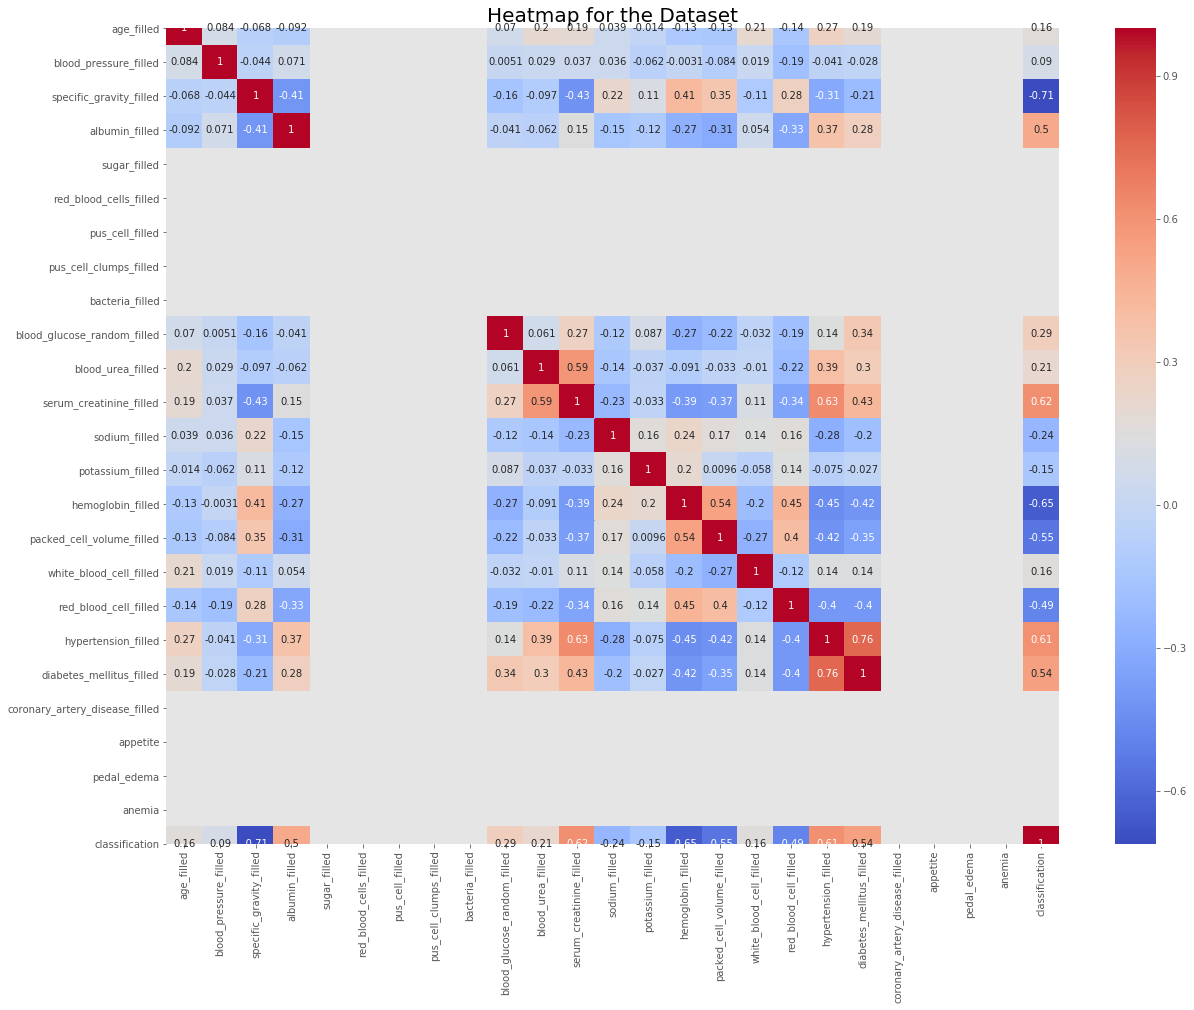

In [52]:
plt.rcParams['figure.figsize'] = (20, 15)
plt.style.use('ggplot')

sns.heatmap(df_outliers_removed.corr(), annot = True, cmap = 'coolwarm')
plt.title('Heatmap for the Dataset', fontsize = 20)
plt.show()

# Plots

In [ ]:
plt.scatter(x=df.hemo_filled[df.classification==1], y=df.pcv_filled[(df.classification==1)], c="red")
plt.scatter(x=df.hemo_filled[df.classification==0], y=df.pcv_filled[(df.classification==0)], c="blue")
plt.legend(["Disease", "Not Disease"])
plt.xlabel("hemo")
plt.ylabel("pcv")
plt.show()

### Frequency of chronic kidney disease across each feature

In [ ]:
pd.crosstab(df.age_filled,df.classification).plot(kind="bar",figsize=(35,10),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Age')
plt.xlabel('Age')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.bp_filled,df.classification).plot(kind="bar",figsize=(15,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Blood Pressure')
plt.xlabel('Blood Pressure')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.sg_filled,df.classification).plot(kind="bar",figsize=(15,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Specific Gravity')
plt.xlabel('Specific Gravity')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.alb_filled,df.classification).plot(kind="bar",figsize=(15,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Albumin')
plt.xlabel('Albumin')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.sugar_filled,df.classification).plot(kind="bar",figsize=(15,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Sugar')
plt.xlabel('Sugar')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.bgr_filled,df.classification).plot(kind="bar",figsize=(15,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Blood glucose random')
plt.xlabel('Blood glucose random')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.bu_filled,df.classification).plot(kind="bar",figsize=(15,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Blood urea')
plt.xlabel('Blood urea')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.sc_filled,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Serum creatinine')
plt.xlabel('Serum creatinine')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.sod_filled ,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Sodium')
plt.xlabel('Sodium')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.pot_filled,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Potassium')
plt.xlabel('Potassium')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.hemo_filled,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Hemoglobin')
plt.xlabel('Hemoglobin')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.pcv_filled,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Packed cell volume')
plt.xlabel('Packed cell volume')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.wbc_filled,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for White blood cell')
plt.xlabel('White blood cell')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.rbc_filled,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Red blood cell')
plt.xlabel('Red blood cell')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.red_blood_cells,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Red blood cells')
plt.xlabel('Red blood cells')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.pus_cell,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Pus cell')
plt.xlabel('Pus cell')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.pus_cell_clumps,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Psus_cell_clumps')
plt.xlabel('Pus_cell_clumps')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.bacteria,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for Bacteria')
plt.xlabel('Bacteria')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.hypertension,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for hypertension')
plt.xlabel('hypertension')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.diabetes_mellitus,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for diabetes_mellitus')
plt.xlabel('diabetes_mellitus')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.coronary_artery_disease,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for coronary_artery_disease')
plt.xlabel('coronary_artery_disease')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.appetite,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for appetite')
plt.xlabel('appetite')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.pedal_edema,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for pedal_edema')
plt.xlabel('pedal_edema')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
pd.crosstab(df.anemia,df.classification).plot(kind="bar",figsize=(35,6),color=['#DAF7A6','#FF5733' ])
plt.title('Chronic Kidney Disease Frequency for anemia')
plt.xlabel('anemia')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency')
plt.show()

In [ ]:
df.rbc_filled.value_counts()[:5]

In [ ]:
pd.crosstab(df.hypertension,df.classification).plot(kind="bar",figsize=(15,6),color=['#FFC300','#581845' ])
plt.title('Chronic Kidney Disease Frequency According To Hypertension')
plt.xlabel('Hypertension - (1 = true; 0 = false)')
plt.xticks(rotation = 0)
plt.legend(["Haven't Disease", "Have Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

In [ ]:
pd.crosstab(df.diabetes_mellitus,df.classification).plot(kind="bar",figsize=(15,6),color=['#11A5AA','#AA1190' ])
plt.title('Chronic Kidney Disease Frequency According To diabetes mellitus')
plt.xlabel('Presence of diabetes mellitus')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

# Split data for modelling

In [ ]:
df.columns

In [ ]:
df_x = df[['age_filled', 'bp_filled', 'sg_filled', 'alb_filled',
       'sugar_filled', 'bgr_filled', 'bu_filled', 'sc_filled', 'sod_filled',
       'pot_filled', 'hemo_filled', 'pcv_filled', 'wbc_filled', 'rbc_filled', 'hypertension', 'diabetes_mellitus',
       'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia']]


# NaNs in X_train

In [ ]:
df_x.isnull().sum()

In [ ]:
df_x.hypertension[df_x.hypertension.isna()]

In [ ]:
df_x.diabetes_mellitus[df_x.diabetes_mellitus.isna()]

In [ ]:
df_x.coronary_artery_disease[df_x.coronary_artery_disease.isna()]

In [ ]:
df_x = df_x[df_x['hypertension'].notna()]

In [ ]:
# How many nulls in the features
df_x.isnull().sum()

In [ ]:
df_y = df[['classification']]

In [ ]:
# How many nulls in the target
df_y.isnull().sum()

## Sklearn Logistic Regression

## Identify features and target to train

In [ ]:
len(X)

In [ ]:
len(y)

In [ ]:
df_x

In [ ]:
df_test

## Before applying to the model, re-order the training data columns to match the test data

In [ ]:
df = df[['age_filled', 'bp_filled', 'sg_filled', 'alb_filled', 'sugar_filled', 'red_blood_cells',
         'pus_cell', 'pus_cell_clumps', 'bacteria', 'bgr_filled', 'bu_filled', 'sc_filled',
         'sod_filled', 'pot_filled', 'hemo_filled', 'pcv_filled', 'wbc_filled', 'rbc_filled',
         'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite',
         'pedal_edema', 'anemia']]

df = df.rename(columns={'bp': 'blood_pressure','sg': 'specific_gravity','al': 'albumin','su': 'sugar',
               'rbc': 'red_blood_cells','pc': 'pus_cell','pcc': 'pus_cell_clumps','ba': 'bacteria',
               'bgr': 'blood_glucose_random','bu': 'blood_urea','sc': 'serum_creatinine',
               'sod': 'sodium','pot': 'potassium','hemo': 'hemoglobin','pcv': 'packed_cell_volume',
               'wc': 'white_blood_cell','rc': 'red_blood_cell','htn': 'hypertension','dm': 'diabetes_mellitus',
               'cad': 'coronary_artery_disease','appet': 'appetite','pe': 'pedal_edema','ane': 'anemia'})
# To-Do
['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane']


## Define training and testing set using test data provided

In [ ]:
df_x.columns

In [ ]:
df_y.columns

In [ ]:
df_test.columns

In [ ]:
X_train = df_x
y_train = df_y
X_test = test.drop("PassengerId", axis=1).copy()

X_train.shape, y_train.shape, X_test.shape

In [ ]:
accuracies = {}

lr = LogisticRegression()
lr.fit(X_train,y_train)
acc = lr.score(X_test,y_test)*100

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.2f}%".format(acc))

## Using the test data provided

In [ ]:
df_test.head()

In [ ]:
df.describe()


In [ ]:
df_test.describe()


In [ ]:
df.columns

In [ ]:
df_test.columns

### Revert names back to abbreviations to test the model

In [ ]:
df = df.rename(columns={'bp': 'blood_pressure','sg': 'specific_gravity','al': 'albumin','su': 'sugar',
                   'rbc': 'red_blood_cells','pc': 'pus_cell','pcc': 'pus_cell_clumps','ba': 'bacteria',
                   'bgr': 'blood_glucose_random','bu': 'blood_urea','sc': 'serum_creatinine',
                   'sod': 'sodium','pot': 'potassium','hemo': 'hemoglobin','pcv': 'packed_cell_volume',
                   'wc': 'white_blood_cell','rc': 'red_blood_cell','htn': 'hypertension','dm': 'diabetes_mellitus',
                   'cad': 'coronary_artery_disease','appet': 'appetite','pe': 'pedal_edema','ane': 'anemia'})


# Random Forest Model

In [ ]:
df_x.isnull().sum()

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train.ravel())

# .values will give the values in an array. (shape: (n,1)
# .ravel will convert that array shape to (n, )

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
def load_data():
    df = pd.read_csv("kidney_disease_train.csv")

    df = df.rename(columns={'bp': 'blood_pressure','sg': 'specific_gravity','al': 'albumin','su': 'sugar',
                   'rbc': 'red_blood_cells','pc': 'pus_cell','pcc': 'pus_cell_clumps','ba': 'bacteria',
                   'bgr': 'blood_glucose_random','bu': 'blood_urea','sc': 'serum_creatinine',
                   'sod': 'sodium','pot': 'potassium','hemo': 'hemoglobin','pcv': 'packed_cell_volume',
                   'wc': 'white_blood_cell','rc': 'red_blood_cell','htn': 'hypertension','dm': 'diabetes_mellitus',
                   'cad': 'coronary_artery_disease','appet': 'appetite','pe': 'pedal_edema','ane': 'anemia'})

    # Coerce numerical values from string to float
    df['white_blood_cell'] = pd.to_numeric(df['white_blood_cell'], errors='coerce')
    df['red_blood_cell'] = pd.to_numeric(df['red_blood_cell'], errors='coerce')

    # Imputing Data
    # With the missing numerical values, we  will fill them in with their means
    df['age_filled'] = df['age'].transform(lambda x: x.fillna(x.mean()))
    df['bp_filled'] = df['blood_pressure'].transform(lambda x: x.fillna(x.mean()))
    df['sg_filled'] = df['specific_gravity'].transform(lambda x: x.fillna(x.mean()))
    df['alb_filled'] = df['albumin'].transform(lambda x: x.fillna(x.mean()))
    df['sugar_filled'] = df['sugar'].transform(lambda x: x.fillna(x.mean()))
    df['bgr_filled'] = df['blood_glucose_random'].transform(lambda x: x.fillna(x.mean()))
    df['bu_filled'] = df['blood_urea'].transform(lambda x: x.fillna(x.mean()))
    df['sc_filled'] = df['serum_creatinine'].transform(lambda x: x.fillna(x.mean()))
    df['sod_filled'] = df['sodium'].transform(lambda x: x.fillna(x.mean()))
    df['pot_filled'] = df['potassium'].transform(lambda x: x.fillna(x.mean()))
    df['hemo_filled'] = df['hemoglobin'].transform(lambda x: x.fillna(x.mean()))
    df['pcv_filled'] = df['packed_cell_volume'].transform(lambda x: x.fillna(x.mean()))
    df['wbc_filled'] = df['white_blood_cell'].transform(lambda x: x.fillna(x.mean()))
    df['rbc_filled'] = df['red_blood_cell'].transform(lambda x: x.fillna(x.mean()))    

    # Create boolean values for each object feature
    df.red_blood_cells = df.red_blood_cells.map({ 'normal' : 1, 'abnormal' : 0})
    df.pus_cell = df.pus_cell.map({ 'normal' : 1, 'abnormal' : 0})
    df.pus_cell_clumps = df.pus_cell_clumps.map({ 'present' : 1, 'notpresent' : 0})
    df.bacteria = df.bacteria.map({ 'present' : 1, 'notpresent' : 0})
    df.hypertension = df.hypertension.map({ 'yes' : 1, 'no' : 0})
    df.diabetes_mellitus = df.diabetes_mellitus.map({ 'yes' : 1, '\tyes' : 1, '\tno' : 0, 'no' : 0})
    df.coronary_artery_disease = df.coronary_artery_disease.map({ 'yes' : 1, 'no' : 0, '\tno' : 0})
    df.appetite = df.appetite.map({ 'good' : 1, 'poor' : 0})
    df.pedal_edema = df.pedal_edema.map({ 'yes' : 1, 'no' : 0})
    df.anemia = df.anemia.map({ 'yes' : 1, 'no' : 0})
    df.classification = df.classification.map({ 'ckd' : 1, 'notckd' : 0})

    # Remove the row where hypertension, diabetes_mellitus, coronary_artery_disease are NaN
    df = df[df['hypertension'].notna()]
    
    # Use the imputed data in the model
    df_x = df[['age_filled', 'bp_filled', 'sg_filled', 'alb_filled',
       'sugar_filled', 'bgr_filled', 'bu_filled', 'sc_filled', 'sod_filled',
       'pot_filled', 'hemo_filled', 'pcv_filled', 'wbc_filled', 'rbc_filled', 'hypertension', 'diabetes_mellitus',
       'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia']]

    # Use the classification as the target
    df_y = df[['classification']]

    X = df_x.values
    y = df_y.values
    return X, y

In [ ]:
def display_results(y_test, y_pred):
    labels = np.unique(y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = (y_pred == y_test).mean()

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

# display results
display_results(y_test, y_pred)

In [ ]:
def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    vect = CountVectorizer(tokenizer=tokenize)
    tfidf = TfidfTransformer()
    clf = RandomForestClassifier()

    # train classifier
    X_train_counts = vect.fit_transform(X_train)
    X_train_tfidf = tfidf.fit_transform(X_train_counts)
    clf.fit(X_train_tfidf, y_train)

    # predict on test data
    X_test_counts = vect.transform(X_test)
    X_test_tfidf = tfidf.transform(X_test_counts)
    y_pred = clf.predict(X_test_tfidf)

    # display results
    display_results(y_test, y_pred)


main()

In [ ]:
knn.fit(X_train, np.ravel(y_train,order='C'))



In [ ]:
# Check how many null values are in the test data set
df_test.isnull().sum()